# 26: Autoencoders for Occlusion

### 🎯 Objective
Can an Autoencoder fix an image that has a "hole" in it? In this notebook, we train a standard autoencoder on clean MNIST digits. Then, during testing, we **occlude** (block out) parts of the image and check if the model can reconstruct the missing pixels based on the surrounding context.

### 📚 Key Concepts
- **Occlusion:** artificially removing information (pixels) from an image.
- **Generalization:** Testing if a model trained on clean data can handle corrupted data.
- **Correlation Metric:** Using Pearson correlation to quantify similarity between images, specifically focusing on non-zero pixels.

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2850606974.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## 1. Import and Process Data
Standard MNIST loading and normalization.

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

## 2. Occlusion Demo

Before building the model, let's define what "occlusion" looks like. We take an image and set a block of pixels to `1` (white), effectively erasing that part of the digit.

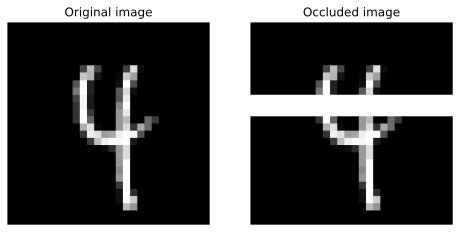

In [3]:
# reconstruct a sample as an image
img = dataT[12345,:].view(28,28)

# Manually occlude a section
occluded = copy.deepcopy( img )
occluded[10:13,:] = 1 # Set rows 10-13 to white (1.0)

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

## 3. Define the Model

We use a slightly different architecture than the previous notebook:
784 $\to$ 128 $\to$ **50** $\to$ 128 $\to$ 784.

In [4]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)

      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

## 4. Train the Model

**Important:** We are training on **CLEAN** images (`yHat` vs `X`). 
We are *not* occluding images during training. We want the model to learn what a *perfect* digit looks like, so that when we give it an imperfect one later, it tries to make it perfect.

In [5]:
def function2trainTheModel():

  # number of epochs
  numepochs = 5

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = []



  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):


    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)

    for batchi in range(numBatches):

      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)


      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # losses in this batch
      losses.append( loss.item() )

  # end epochs

  # function output
  return losses,net

## 5. Run Training

Final loss: 0.0109


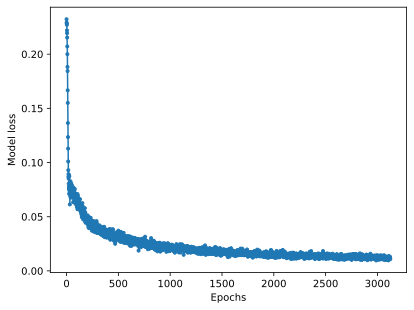

In [6]:
# train the model (16s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

## 6. The Occlusion Experiment

Now we test the model. We create a batch of 10 images and occlude them either vertically or horizontally.

**Prediction:** Since the model knows what digits look like, it should "guess" that the white bar shouldn't be there and replace it with pixels that match the rest of the digit.

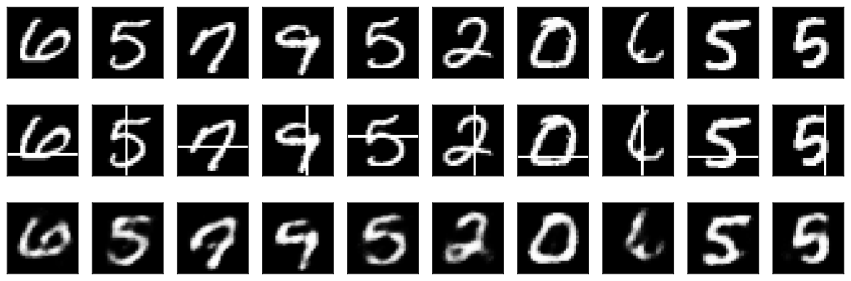

In [7]:
# grab a small set of images
X = copy.deepcopy( dataT[:10,:] )

# add noise
for i in range(X.shape[0]):

  # reshape the image
  img = X[i,:].view(28,28)

  # occlude random rows or columns
  startloc = np.random.choice(range(10,21))
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1



# run the samples through the model
deOccluded = net(X)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

## 7. Quantitative Evaluation (Correlation)

We want to measure how well the model fixed the image. 
Using **Pixel Correlation** (Correlation between Original and Reconstructed pixels) is a good metric.

**However:** Most pixels are black (0). If the model correctly predicts "black" for the background, the correlation will be artificially high. We care about the *active* pixels (the digit itself).

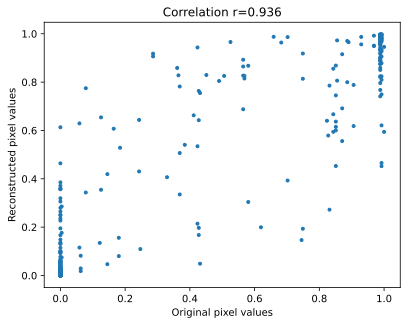

In [8]:
# We can quantify the performance of our "de-occluder" by correlating the sample with the original.

inOutCorr = np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())

# and plot
plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

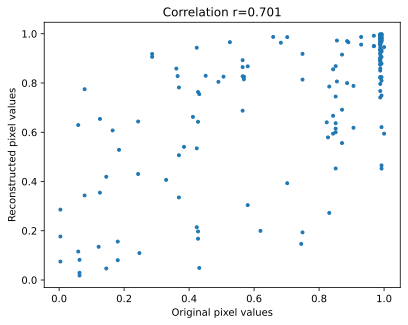

In [9]:
# try again without the zero-valued pixels

# extract to variables for convenience
orig  = dataT[9,:].detach()
recon = deOccluded[9,:].detach()

# boolean vector that indicates pixels>0 (with some tolerance)
tol = 1e-4
nonzeropixels = (orig>tol) & (recon>tol)

# then re-compute the correlation
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

# redraw the previous plot
plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

### Comparing Results
Let's compare the correlation of the Reconstructed (Occluded input) vs. the Reconstructed (No-Occlusion input).
We expect the correlation to be slightly lower for the Occluded images because the model had to guess, but ideally not *too* much lower.

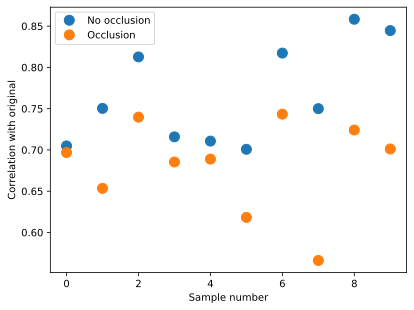

In [10]:
# get data with no occlusion
noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()